In [122]:
import os
print os.getcwd()

/Users/weidian1/Documents/GitHub/Udacity-DAND/P5-Intro to ML/Project5/final_project


In [123]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")
#sys.path.append("../pylof-master/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
#features_list = ['poi','salary',''] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


## 数据探索

In [124]:
# 异常值， 去掉total
def remove_outerliers(data_dict,names):
    for name in names:
        data_dict.pop(name, 0)
    return data_dict

def dateset_summary(data_dic):
    n_poi,n_non_poi = 0,0
    for key in data_dict.keys():
        if data_dict[key]['poi']==1:
            n_poi+=1
        else:
            n_non_poi+=1        
    print "Total number of data points: ", len(data_dict)
    print "Number of POI: %d, no. of non-POI: %d"% (n_poi, n_non_poi)
    print "Number of features used: ",len(data_dict['METTS MARK']) # randomly pick one name, get the number of features.

outliers_names =  ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']#['TOTAL']#,'LAVORATO JOHN J'

data_dict = remove_outerliers(data_dict,outliers_names)
dateset_summary(dateset_summary)

Total number of data points:  143
Number of POI: 18, no. of non-POI: 125
Number of features used:  21


In [125]:
import pandas as pd
import numpy as np

data_df = pd.DataFrame.from_dict(data_dict,orient='index')

financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus'
                 , 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses'
                 , 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock'
                 , 'director_fees']
email_fatures = ['to_messages','from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi'
                 , 'shared_receipt_with_poi']  # remove 'email_address'
def NaNs_to_0s(col):
    return [0 if ele=='NaN' else ele for ele in col]

def NaNs_to_None(col):
    return [None if ele=='NaN' else ele for ele in col]

def count_NAN(col):
    return sum(1 for ele in col if ele == 'NaN')

data_df[financial_features] = data_df[financial_features].apply(NaNs_to_0s, axis=0)
data_df['poi'] = data_df['poi'].astype(int)
print data_df.apply(count_NAN, axis=0)   

salary                        0
to_messages                  57
deferral_payments             0
total_payments                0
exercised_stock_options       0
bonus                         0
restricted_stock              0
shared_receipt_with_poi      57
restricted_stock_deferred     0
total_stock_value             0
expenses                      0
loan_advances                 0
from_messages                57
other                         0
from_this_person_to_poi      57
poi                           0
director_fees                 0
deferred_income               0
long_term_incentive           0
email_address                32
from_poi_to_this_person      57
dtype: int64


## plot

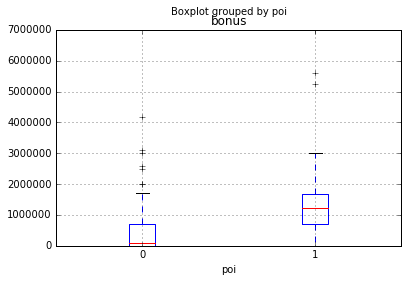

In [154]:
%matplotlib inline
data_df.boxplot('bonus', by='poi')

## add new features

In [126]:
"""
make new feature 
1. 'email_features_miss': if email_features is missing. next step, missing email_features will be
transformed to 0, which should by different from missing financial features.   
2. poi_rate_to_messages = from_this_person_to_poi/to_messages  
3. poi_rate_from_messages = from_poi_to_this_person/from_messages

"""
data_df['email_features_miss'] = data_df.apply(lambda x: 1 if x["to_messages"]=='NaN' else 0, axis = 1)

data_df['poi_rate_to_messages'] = data_df.apply(lambda x: 0 if x['from_this_person_to_poi']=='NaN' \
                                                else x['from_this_person_to_poi']*1.0/x['to_messages'], axis=1)

data_df['poi_rate_from_messages'] = data_df.apply(lambda x: 0 if x['from_poi_to_this_person']=='NaN'\
                                                  else x['from_poi_to_this_person']*1.0/x['from_messages'], axis =1)



    

In [127]:
print data_df.shape#columns.values; 24个变量
print data_df.columns.values

(143, 24)
['salary' 'to_messages' 'deferral_payments' 'total_payments'
 'exercised_stock_options' 'bonus' 'restricted_stock'
 'shared_receipt_with_poi' 'restricted_stock_deferred' 'total_stock_value'
 'expenses' 'loan_advances' 'from_messages' 'other'
 'from_this_person_to_poi' 'poi' 'director_fees' 'deferred_income'
 'long_term_incentive' 'email_address' 'from_poi_to_this_person'
 'email_features_miss' 'poi_rate_to_messages' 'poi_rate_from_messages']


## 这些新变量不要了

In [156]:
"""create new features
"""
def get_new(col,p):
    return (data_df[col].apply(abs)/(10**(p-1))%10).astype(int)
def over_zero(ele):
    if ele>0:
        return 1
    return 0

def add_new_features(df):
    df["bonus_over_zero"] = df['bonus'].apply(over_zero)
    df["bonus_six"] = get_new("bonus",6)
    df["bonus_seven"] = get_new("bonus",7)
    
    df["expenses_over_zero"] = df["expenses"].apply(over_zero)
    df["expenses_five"] = get_new("expenses",5)
    df["expenses_six"] = get_new("expenses",6)
    
    df["exercised_stock_options_over_zero"] = df["exercised_stock_options"].apply(over_zero)
    df["exercised_stock_options_six"] = get_new("exercised_stock_options",6)
    df["exercised_stock_options_seven"] = get_new("exercised_stock_options",7)
    df["exercised_stock_options_eight"] = get_new("exercised_stock_options",8)
    
    df["salary_over_zero"] = df["salary"].apply(over_zero)
    df["salary_six"] = get_new("salary",6)
    df["salary_seven"] = get_new("salary",7)
    
    df["restricted_stock_over_zero"] = df["restricted_stock"].apply(over_zero)
    df["restricted_stock_six"] = get_new("restricted_stock",6)
    df["restricted_stock_seven"] = get_new("restricted_stock",7)
    df["restricted_stock_eight"] = get_new("restricted_stock",8)
    
    df["deferred_income_over_zero"] = df["deferred_income"].apply(over_zero)
    df["deferred_income_five"] = get_new("deferred_income",5)
    df["deferred_income_six"] = get_new("deferred_income",6)
    df["deferred_income_seven"] = get_new("deferred_income",7)
    
    df["other_over_zero"] = df["other"].apply(over_zero)
    df["other_six"] = get_new("other",6)
    df["other_seven"] = get_new("other",7)
    df["other_eight"] = get_new("other",8)
    return df

data_df = add_new_features(data_df)

## get mydata(dic)

In [128]:
features_full_list = list(data_df.columns.values)
features_full_list.remove('email_address')
features_full_list.remove('poi')
features_full_list = ['poi'] +features_full_list
data_full_dic = data_df.to_dict(orient='index')
print ("%d full_columns_name: %s" % (len(features_full_list), features_full_list))

#def get_train_test_dataset(my_dataset,features_list):
#    #Extract features and labels from dataset for local testing
#    data = featureFormat(my_dataset, features_list, sort_keys = True)
#    labels, features = targetFeatureSplit(data)
#    # TODO: Shuffle the data
#    from sklearn.utils import shuffle
#    features, labels = shuffle(features, labels, random_state=1)
#    
#    # split train test dataset
#    from sklearn.model_selection import train_test_split
#    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
#    X_train = np.array(X_train)
#    y_train = np.array(y_train)
#    X_test = np.array(X_test)
#    y_test = np.array(y_test)
#    
#    return X_train, X_test, y_train, y_test
#    
#X_train, X_test, y_train, y_test = get_train_test_dataset(data_full_dic,features_full_list)  
    
def get_features_labels(my_dataset,features_list):
    #Extract features and labels from dataset for local testing
    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    # TODO: Shuffle the data
    from sklearn.utils import shuffle
    features, labels = shuffle(features, labels, random_state=1)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

def get_train_test_dataset(features, labels):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test
  
features, labels = get_features_labels(data_full_dic,features_full_list)
X_train, X_test, y_train, y_test = get_train_test_dataset(features, labels)

23 full_columns_name: ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'email_features_miss', 'poi_rate_to_messages', 'poi_rate_from_messages']


In [185]:
data_df[data_df['loan_advances']>0][['poi','loan_advances']]

,poi,loan_advances
FREVERT MARK A,0,2000000
LAY KENNETH L,1,81525000
PICKERING MARK R,0,400000


## scaler

In [8]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

## select features

In [347]:
"""
select important features 
"""
def select_features(X_train,y_train,X_test, method='tree',k=None):
    from sklearn.utils import shuffle
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    if method == 'tree':
        
        from sklearn.ensemble import ExtraTreesClassifier
        from sklearn.feature_selection import SelectFromModel   

        selection_tree = ExtraTreesClassifier(random_state=32)
        selection_tree = selection_tree.fit(X_train, y_train)

        model_tree = SelectFromModel(selection_tree, prefit=True)
        X_train_new = model_tree.transform(X_train)
        X_test_new = model_tree.transform(X_test)
        
        print "shape of X_train: ", X_train.shape
        print "shape of X_train_new: ", X_train_new.shape    
        return selection_tree,X_train_new,X_test_new
    
    elif method == 'kbest' and k:
        from sklearn.feature_selection import SelectKBest
        from sklearn.feature_selection import f_classif

        selection_k= SelectKBest(f_classif, k=k).fit(X_train, y_train)
        X_train_new = selection_k.transform(X_train)
        X_test_new = selection_k.transform(X_test)
        print "shape of X_train: ", X_train.shape
        print "shape of X_train_new: ", X_train_new.shape   
        return selection_k,X_train_new,X_test_new
        
    




In [348]:
#selection_tree,X_train_new,X_test_new = select_features(X_train_scaled,y_train,X_test_scaled)
X_train_new,X_test_new = X_train_scaled,X_test_scaled

In [10]:
selection_k,X_train_new,X_test_new = select_features(X_train_scaled,y_train,X_test_scaled,method='kbest',k=10)

shape of X_train:  (101, 22)
shape of X_train_new:  (101, 10)


## train algorithm

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
def train_model(classifier,features_train,labels_train,features_test):
    clf = classifier
    clf.fit(features_train, labels_train)
    labels_pred = clf.predict(features_test)
    return clf,labels_pred

## evaluation metrics

In [9]:
def evaluation_metric(labels_test,labels_pred):
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import f1_score
    
    print "recall_score: ",recall_score(y_test, labels_pred)
    print "precision_score: ",precision_score(labels_test, labels_pred)  
    print "f1_score: ",f1_score(labels_test, labels_pred)  
  

### 用tree 的到的features，建模，问题
navie bayers 和 decision tree 完全反的;    
SVM，randomforest 出现no TP

In [362]:
# naive bayers
clf_nb,y_pred_nb = train_model(GaussianNB(),X_train,y_train,X_test)
evaluation_metric(y_test,y_pred_nb)

recall_score:  0.444444444444
precision_score:  0.5
f1_score:  0.470588235294


In [361]:
clf_nb,y_pred_nb = train_model(GaussianNB(),X_train_scaled,y_train,X_test_scaled)
evaluation_metric(y_test,y_pred_nb)


recall_score:  0.666666666667
precision_score:  0.214285714286
f1_score:  0.324324324324


In [357]:
#svm
clf_svm,y_pred_svm = train_model(SVC(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_svm)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


In [355]:
# decision tree
clf_dtree,y_pred_stree = train_model(tree.DecisionTreeClassifier(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_stree)

recall_score:  0.111111111111
precision_score:  0.25
f1_score:  0.153846153846


In [352]:
# random forest

clf_froest,y_pred_forest = train_model(RandomForestClassifier(n_estimators=10),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_forest)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


## Kbest 

In [215]:
# naive bayers
clf_nb,y_pred_nb = train_model(GaussianNB(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_nb)

recall_score:  0.666666666667
precision_score:  0.285714285714
f1_score:  0.4


In [216]:
#svm
clf_svm,y_pred_svm = train_model(SVC(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_svm)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


In [217]:
# decision tree
clf_dtree,y_pred_stree = train_model(tree.DecisionTreeClassifier(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_stree)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


In [218]:
# random forest

clf_froest,y_pred_forest = train_model(RandomForestClassifier(n_estimators=10),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_forest)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


## Pipiline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe 


In [ ]:
from sklearn.model_selection import GridSearchCV
params = dict(reduce_dim__n_components=[2, 5, 10],
              clf__C=[0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=params)

In [ ]:
from sklearn.linear_model import LogisticRegression
params = dict(reduce_dim=[None, PCA(5), PCA(10)],
              clf=[SVC(), LogisticRegression()],
              clf__C=[0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=params)

In [145]:
import pandas as pd
from numpy import mean,std
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)




class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        model_tree = SelectFromModel(ExtraTreesClassifier(random_state=32), prefit=False)
        
        preparation = [#('scaler',min_max_scaler),
                      ('selector',model_tree)]
        self.params_selector ={'selector__threshold':['0.5*mean','0.8*mean','mean','1.2*mean','1.4*mean'] }
        
        self.preparation = preparation
        self.scores_df = None

    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=True):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            #params = self.params[key]
            if isinstance(self.params[key],list):
                params = [dict(param.items() + self.params_selector.items()) for param in self.params[key]]           
            elif isinstance(self.params[key],dict):
                params = dict(self.params[key].items() + self.params_selector.items())
            preparation = self.preparation
            pipe= Pipeline(preparation +[(key,model)])        
            gs = GridSearchCV(pipe, params, cv=cv, n_jobs=n_jobs,verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': mean(scores),
                 'std_score': std(scores),
            }
            return pd.Series(dict(params.items() + d.items()))

        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values(by=[sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        self.scores_df = df[columns]
        return df[columns]
    
    def best_estimator_model(self):
        if  isinstance(self.scores_df,pd.DataFrame):
            model_name = self.scores_df.iloc[0,0]
            best_estimator_ = self.grid_searches[model_name].best_estimator_
            best_model = self.grid_searches[model_name].best_estimator_.steps[-1][-1]
            return best_estimator_, best_model       
        else:
            raise ValueError('scores_df is None; run fit() and score_summary() first')

In [143]:
models1 = { 
    #'ExtraTreesClassifier': ExtraTreesClassifier(),
    #'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=32)#,
    #'GradientBoostingClassifier': GradientBoostingClassifier()
    #'SVC': SVC()
}

params1 = { 
    'ExtraTreesClassifier': { 'ExtraTreesClassifier__n_estimators': [16, 32, 50, 100] },
    'RandomForestClassifier': { 'RandomForestClassifier__n_estimators': [16, 32, 50, 100] },
    'AdaBoostClassifier':  { 'AdaBoostClassifier__n_estimators': [16, 32, 50, 100]
                             ,'AdaBoostClassifier__learning_rate':[0.5
                                                                   # , 0.8
                                                                   , 1.0
                                                                   , 1.5
                                                                   ,2
                                                                   ,2.5
                                                                   ,3
                                                                   ,3.5
                                                                   ,4
                                                                   , 5]
                           #  ,'AdaBoostClassifier__base_estimator':['DecisionTreeClassifier','GaussianNB']
                           #  ,'AdaBoostClassifier__algorithm':['SAMME', 'SAMME.R']
                           },
    'GradientBoostingClassifier': { 'GradientBoostingClassifier__n_estimators': [16, 32, 50, 100]
                                   , 'GradientBoostingClassifier__learning_rate': [0.5, 0.8, 1.0] }
    #'SVC': [
    #    {'SVC__kernel': ['linear'], 'SVC__C': [1, 10]},
    #    {'SVC__kernel': ['rbf'], 'SVC__C': [1, 10], 'SVC__gamma': [0.001, 0.0001]},
    #]
}

from sklearn.metrics import recall_score, precision_score, f1_score
def scorer_r_p(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    r_score = recall_score(y_test, y_pred)
    p_score = precision_score(y_test, y_pred)
#    f1_score = f1_score(y_test, y_pred)
    if r_score<0.3 or p_score<0.3:
        return 0
    return  f1_score(y_test, y_pred)


from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(labels, n_iter=50, test_size = 0.2, random_state=42)

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(features, labels,cv=sss, scoring=scorer_r_p, n_jobs=-1)

Running GridSearchCV for AdaBoostClassifier.
Fitting 50 folds for each of 108 candidates, totalling 5400 fits


/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
Process PoolWorker-63:
Traceback (most recent call last):
  File "/Users/weidian1/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/weidian1/anaconda/lib/python2.7/m

KeyboardInterrupt: 

In [130]:
scores_df1 = helper1.score_summary()
#scores_df.iloc[0,0]
best_estimator_1,best_model1 = helper1.best_estimator_model()
print "best model1: ",best_model1

best model1:  AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=100, random_state=32)


In [131]:
best_estimator_1

Pipeline(steps=[('selector', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_l...hm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=100, random_state=32))])

In [135]:
scores_df1.head(10)

,estimator,min_score,mean_score,max_score,std_score,AdaBoostClassifier__learning_rate,AdaBoostClassifier__n_estimators,selector__threshold
9,AdaBoostClassifier,0,0.235825,0.8,0.27439,0.5,100,mean
18,AdaBoostClassifier,0,0.224322,0.75,0.282789,1,50,mean
21,AdaBoostClassifier,0,0.220937,0.857143,0.2953,1,100,mean
7,AdaBoostClassifier,0,0.219548,0.75,0.265633,0.5,50,0.5*mean
37,AdaBoostClassifier,0,0.216231,0.75,0.273437,2,16,0.5*mean
24,AdaBoostClassifier,0,0.210302,0.75,0.253334,1.5,16,mean
33,AdaBoostClassifier,0,0.210084,0.666667,0.263864,1.5,100,mean
19,AdaBoostClassifier,0,0.205163,0.666667,0.256598,1,50,0.5*mean
27,AdaBoostClassifier,0,0.20475,0.666667,0.257077,1.5,32,mean
11,AdaBoostClassifier,0,0.193667,0.857143,0.26847,0.5,100,1.4*mean


In [111]:
scores_df1[scores_df1['AdaBoostClassifier__learning_rate']==2]


,estimator,min_score,mean_score,max_score,std_score,AdaBoostClassifier__learning_rate,AdaBoostClassifier__n_estimators,selector__threshold
24,AdaBoostClassifier,0,0.189382,0.6,0.234758,2,16,mean
27,AdaBoostClassifier,0,0.181643,0.666667,0.247919,2,32,mean
33,AdaBoostClassifier,0,0.153104,0.666667,0.238825,2,100,mean
30,AdaBoostClassifier,0,0.150564,0.666667,0.235008,2,50,mean
28,AdaBoostClassifier,0,0.143971,0.666667,0.245561,2,32,0.5*mean
31,AdaBoostClassifier,0,0.13112,0.666667,0.2359,2,50,0.5*mean
34,AdaBoostClassifier,0,0.126675,0.666667,0.240379,2,100,0.5*mean
35,AdaBoostClassifier,0,0.121062,0.615385,0.217005,2,100,1.4*mean
32,AdaBoostClassifier,0,0.119062,0.615385,0.213943,2,50,1.4*mean
25,AdaBoostClassifier,0,0.118485,0.6,0.21334,2,16,0.5*mean


In [87]:
for step in best_estimator_1.steps:
    print step[0],step[1]

selector SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=32,
           verbose=0, warm_start=False),
        prefit=False, threshold='mean')
AdaBoostClassifier AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=2,
          n_estimators=16, random_state=32)


In [43]:
selector_forest = best_estimator_1.steps[1][-1].estimator_
selector_forest

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=32,
           verbose=0, warm_start=False)

Feature ranking:
1. feature 16 (0.117440)
2. feature 17 (0.112995)
3. feature 5 (0.104677)
4. feature 9 (0.067156)
5. feature 0 (0.066105)
6. feature 2 (0.054996)
7. feature 21 (0.054970)
8. feature 3 (0.052955)
9. feature 6 (0.051453)
10. feature 18 (0.048225)
11. feature 7 (0.043556)
12. feature 13 (0.039803)
13. feature 4 (0.038056)
14. feature 1 (0.034536)
15. feature 12 (0.031553)
16. feature 10 (0.026751)
17. feature 11 (0.021461)
18. feature 20 (0.017219)
19. feature 14 (0.007846)
20. feature 8 (0.004066)
21. feature 19 (0.003613)
22. feature 15 (0.000567)


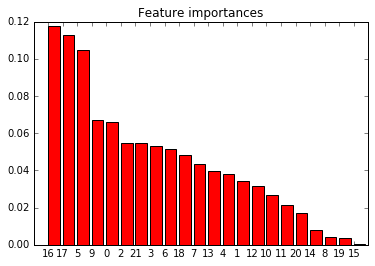

In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

selector_forest.fit(X_train , y_train)
importances = selector_forest.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_scaled .shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],color="r")#, yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

### AdaBoost

In [203]:
from sklearn.ensemble import AdaBoostClassifier  
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, f1_score

def scorer_r_p(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    r_score = recall_score(y_test, y_pred, average='micro')
    p_score = precision_score(y_test, y_pred, average='micro')
    if r_score<0.3 or p_score<0.3:
        return 0
    return  f1_score(y_test, y_pred, average='micro')



sss = StratifiedShuffleSplit(labels, n_iter=50, test_size = 0.2, random_state=42)

#helper1 = EstimatorSelectionHelper(models1, params1)
#helper1.fit(features, labels,cv=sss, scoring=scorer_r_p, n_jobs=-1)


pipe = Pipeline([('scaler',MinMaxScaler(feature_range=(0,1))), 
                ('selector', SelectKBest(k=6)),
                  ('classifier', AdaBoostClassifier(random_state=32))])
param_grid = dict( selector__score_func=[chi2,f_classif],
                  #selector__k=range(5,13),
                 classifier__n_estimators=[50,80]#,100]
                 ,classifier__learning_rate=[0.2,0.3,0.4,0.5]#,0.6,0.8,1]#,2,3,4]
                 )

clf_grid = GridSearchCV(pipe, param_grid, scoring=scorer_r_p, cv=sss, n_jobs=-1)
clf_grid.fit(features, labels)

/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [11] are constant.
  UserWarning)
/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [11] are constant.
  UserWarning)
/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [11] are constant.
  UserWarning)
/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [11] are constant.
  UserWarning)


GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  0.  0.], n_iter=50, test_size=0.2, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function f_classif at 0x113480938>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=32))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'classifier__learning_rate': [0.2, 0.3, 0.4, 0.5], 'classifier__n_estimators': [50, 80], 'selector__score_func': [<function chi2 at 0x113480a28>, <function f_classif at 0x113480938>]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function scorer_r_p at 0x117f861b8>, verbose=0)

In [204]:
clf_grid.get_params

<bound method GridSearchCV.get_params of GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  0.  0.], n_iter=50, test_size=0.2, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function f_classif at 0x113480938>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=32))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'classifier__learning_rate': [0.2, 0.3, 0.4, 0.5], 'classifier__n_estimators': [50, 80], 'selector__score_func': [<function chi2 at 0x113480a28>, <function f_classif at 0x113480938>]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function scorer_r_p at 0x117f861b8>, verbose=0)>

In [205]:
#clf.grid_scores_
clf_grid.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function chi2 at 0x113480a28>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.2, n_estimators=50, random_state=32))])

## Task 6:
Dump your classifier, dataset, and features_list so anyone can
check your results. You do not need to change anything below, but make sure that the version of poi_id.py that you submit can be run on its own and generates the necessary .pkl files for validating your results.



In [206]:
from tester import dump_classifier_and_data
#clf = GaussianNB()#best_estimator_
#features_list = [features_full_list[1:][index] for index,importance in enumerate(importances) if importance>=1.4*mean(importances)]
#features_list = ['poi']+features_list
features_list = features_full_list
my_dataset = data_full_dic

#best_estimator_1.set_params(AdaBoostClassifier__n_estimators=50, AdaBoostClassifier__learning_rate=1) 
#clf = best_estimator_1
clf = clf_grid.best_estimator_
#clf = Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
#                      ('selector', SelectKBest(k=6, score_func=f_classif)),
#                      ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
#                                                        learning_rate=1, n_estimators=100, random_state=32))])

dump_classifier_and_data(clf, my_dataset, features_list)

In [89]:
#best_estimator_1.steps
best_estimator_1

Pipeline(steps=[('selector', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_l...rithm='SAMME.R', base_estimator=None, learning_rate=2,
          n_estimators=16, random_state=32))])

In [90]:
best_estimator_1.set_params(AdaBoostClassifier__n_estimators=50) 

Pipeline(steps=[('selector', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_l...rithm='SAMME.R', base_estimator=None, learning_rate=2,
          n_estimators=50, random_state=32))])

## Test

In [208]:
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )

        ### fit the classifier using training set, and test on test set

        clf.fit(features_train, list(labels_train))
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."


clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1.5, n_estimators=50, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)


Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function chi2 at 0x113480a28>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=50, random_state=32))])
	Accuracy: 0.83567	Precision: 0.35675	Recall: 0.28950	F1: 0.31962	F2: 0.30084
	Total predictions: 15000	True positives:  579	False positives: 1044	False negatives: 1421	True negatives: 11956



In [209]:
clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1.5, n_estimators=100, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)


Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function chi2 at 0x113480a28>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=100, random_state=32))])
	Accuracy: 0.83547	Precision: 0.35038	Recall: 0.27400	F1: 0.30752	F2: 0.28649
	Total predictions: 15000	True positives:  548	False positives: 1016	False negatives: 1452	True negatives: 11984



In [216]:
clf=Pipeline(steps=[#('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=f_classif)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1.5, n_estimators=100, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)


Pipeline(steps=[('selector', SelectKBest(k=6, score_func=<function f_classif at 0x113480938>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=100, random_state=32))])
	Accuracy: 0.82413	Precision: 0.29887	Recall: 0.23700	F1: 0.26436	F2: 0.24724
	Total predictions: 15000	True positives:  474	False positives: 1112	False negatives: 1526	True negatives: 11888



In [ ]:
clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1, n_estimators=50, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)


In [ ]:
clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1, n_estimators=100, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)

In [ ]:
clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1, n_estimators=50, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)

In [211]:
clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1.8, n_estimators=50, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function chi2 at 0x113480a28>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.8, n_estimators=50, random_state=32))])
	Accuracy: 0.83280	Precision: 0.34340	Recall: 0.27850	F1: 0.30756	F2: 0.28944
	Total predictions: 15000	True positives:  557	False positives: 1065	False negatives: 1443	True negatives: 11935



In [ ]:
clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1.8, n_estimators=100, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)

In [212]:
clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1.2, n_estimators=50, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function chi2 at 0x113480a28>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.2, n_estimators=50, random_state=32))])
	Accuracy: 0.84040	Precision: 0.37073	Recall: 0.28250	F1: 0.32066	F2: 0.29662
	Total predictions: 15000	True positives:  565	False positives:  959	False negatives: 1435	True negatives: 12041



In [213]:
clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1.2, n_estimators=30, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function chi2 at 0x113480a28>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.2, n_estimators=30, random_state=32))])
	Accuracy: 0.83780	Precision: 0.35987	Recall: 0.27800	F1: 0.31368	F2: 0.29125
	Total predictions: 15000	True positives:  556	False positives:  989	False negatives: 1444	True negatives: 12011



In [ ]:
clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1.2, n_estimators=30, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)

In [214]:
clf=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                    ('selector', SelectKBest(k=6, score_func=chi2)),
                    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                                      learning_rate=1.2, n_estimators=100, random_state=32))])
test_classifier(clf, data_full_dic, features_full_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function chi2 at 0x113480a28>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.2, n_estimators=100, random_state=32))])
	Accuracy: 0.83740	Precision: 0.35569	Recall: 0.27050	F1: 0.30730	F2: 0.28411
	Total predictions: 15000	True positives:  541	False positives:  980	False negatives: 1459	True negatives: 12020



0.022727272727272724

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, f1_score


In [21]:
import pandas as pd
from numpy import mean,std
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
model_tree = SelectFromModel(ExtraTreesClassifier(random_state=32), prefit=False)

models = { 
    'GaussianNB':GaussianNB(),
    #'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()#,
    #'SVC': SVC()
}

params_s = { 
    'GaussianNB': {'GaussianNB__priors':[None,[0.124,0.876]]},
    #'ExtraTreesClassifier': { 'ExtraTreesClassifier__n_estimators': [16, 32] },
    'RandomForestClassifier': { 'RandomForestClassifier__n_estimators': [16, 32,50,100],
                                'RandomForestClassifier__min_samples_split': [2,3,4],
                                'RandomForestClassifier__max_features':[3,4,5]},                   
    'AdaBoostClassifier':  { 'AdaBoostClassifier__n_estimators': [16, 32]},
    'GradientBoostingClassifier': { 'GradientBoostingClassifier__n_estimators': [16, 32],
                                    'GradientBoostingClassifier__learning_rate': [0.8, 1.0]}#,
    #'SVC':[
    #    {'SVC__kernel': ['linear'], 'SVC__C': [1, 10]},
    #    {'SVC__kernel': ['rbf','linear'], 'SVC__C': [1, 10], 'SVC__gamma': ['auto', 0.001, 0.0001]}
    #   ]
}

params_selector ={'selector__threshold':['mean','0.5*mean','1.4*mean'] }

keys = models.keys()
grid_searches = {}
    
preparation = [('scaler',min_max_scaler)
              ,('selector',model_tree)]

def scorer_r_p(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    r_score = recall_score(y_test, y_pred)
    p_score = precision_score(y_test, y_pred)
#    f1_score = f1_score(y_test, y_pred)
    if r_score<0.3 or p_score<0.3:
        return 0    
    return r_score + p_score

#------------------------fit ------------------------
for key in models.keys():
    print("------Running GridSearchCV for %s.------" % key)
    model = models[key]
    params = params_s[key]
    if isinstance(params_s[key],list):
        params = [dict(param.items() + params_selector.items()) for param in params_s[key]]           
    elif isinstance(params_s[key],dict):
        params = dict(params_s[key].items() + params_selector.items())
    estimators = preparation+[(key,model)]
    print estimators
    pipe= Pipeline(estimators) 
    print pipe
    gs = GridSearchCV(pipe, params, cv=3, n_jobs=1, verbose=1, scoring='f1', refit=True)
    gs.fit(X_train,y_train)
    grid_searches[key] = gs     

#------------------scores summary-------------------------    
def row(k,scores,params):
    d = {
        'estimators': k,
        'mean_score': mean(scores),
        'min_score': min(scores),
        'max_score': max(scores),
        'std_score': std(scores)
    }
    return pd.Series(dict(d.items() + params.items()))


rows = [row(k, gs.cv_validation_scores,gs.parameters)
       for k in keys 
           for gs in grid_searches[k].grid_scores_]
df = pd.concat(rows, axis=1).T.sort_values('mean_score',ascending=False)
columns = ['estimators','mean_score','min_score','max_score','std_score']
columns = columns + [col for col in df.columns.values if col not in columns]
print df[columns]

#-----------------best classifier------------------
#grid_searches['AdaBoostClassifier'].best_estimator_.steps[2][1]


------Running GridSearchCV for GaussianNB.------
[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=32,
           verbose=0, warm_start=False),
        prefit=False, threshold=None)), ('GaussianNB', GaussianNB(priors=None))]
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_le... warm_start=False),
        prefit=False, threshold=None)), ('GaussianNB', Gaussian

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.4s finished


------Running GridSearchCV for AdaBoostClassifier.------
[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=32,
           verbose=0, warm_start=False),
        prefit=False, threshold=None)), ('AdaBoostClassifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impu

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.6s finished


------Running GridSearchCV for GradientBoostingClassifier.------
[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=32,
           verbose=0, warm_start=False),
        prefit=False, threshold=None)), ('GradientBoostingClassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              su

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.8s finished


------Running GridSearchCV for RandomForestClassifier.------
[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=32,
           verbose=0, warm_start=False),
        prefit=False, threshold=None)), ('RandomForestClassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]
Pipeline(ste

/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: max_features must be in (0, n_features]

In [214]:
grid_searches[df[columns].iloc[0,0]].best_estimator_.steps

[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('selector',
  SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_jobs=1, oob_score=False, random_state=32,
             verbose=0, warm_start=False),
          prefit=False, threshold='0.5*mean')),
 ('AdaBoostClassifier',
  AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
            learning_rate=1.0, n_estimators=32, random_state=None))]

In [146]:
#clf.best_score_
clf

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

### 用 model_selection 中的GridSearchCV

In [23]:
import pandas as pd
from numpy import mean,std
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV

'''
refit : boolean, default=True
Refit the best estimator with the entire dataset. 
If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
'''


class ModelsSelector(object):
	"""docstring for ClassName"""
	def __init__(self, models, params):
		if not set(models.keys()).issubset(set(params.keys())):
			miss_models =  set(models.keys()) - set(params.keys())
			raise ValueError("Some models are missing parameters: %s ." % miss_models)
		self.models = models
		self.params = params
		self.keys = models.keys()
		self.grid_select = {}

	def fit(self, X, y, cv=3, scoring=None, refit=False, verbose=1, n_jobs=1):
		for key in self.keys:
			print ("Running GridSelectCV for %s ." % key)
			model = self.models[key]
			params = self.params[key]
			gs_cv = GridSearchCV(model, param_grid=params, cv=cv, scoring=scoring,
								n_jobs=n_jobs, refit=refit, verbose=verbose)
			gs_cv.fit
			self.grid_select[key] = gs_cv


	def score_summary(self,sort_by='mean_score'):
		evaluate_keys = ['mean_test_score','std_test_score','mean_train_score','std_train_score','params','rank_test_score']
		cv_result_dfs = []
		for k in self.keys:
			cv_result_dict = {}
			for gs_cv_result_k, gs_cv_result_v in self.grid_select[k].cv_results_.items():
				#cv_result_df = pd.DataFrame.from_dict(cv_results_,orient='columns')
				if gs_cv_result_k in evaluate_keys:
					cv_result_dict[gs_cv_result_k] = gs_cv_result_v
 			cv_result_dict['estimator'] = [k]*len(self.grid_select[k].cv_results_['mean_test_score'])
 			cv_result_df = pd.DataFrame.from_dict(cv_result_dict,orient='columns')
 			cv_result_dfs.append(cv_result_df)
 #[mydict[x] for x in evaluate_keys]
 		cv_results = pd.concat(cv_result_dfs)
 		return cv_results


In [39]:
helper2 = ModelsSelector(models1, params1)
helper2.fit(X_train_new,y_train,cv=3, scoring='f1', n_jobs=-1)

Running GridSelectCV for SVC .
Running GridSelectCV for AdaBoostClassifier .
Running GridSelectCV for GradientBoostingClassifier .
Running GridSelectCV for ExtraTreesClassifier .
Running GridSelectCV for RandomForestClassifier .


In [40]:
helper2.score_summary(sort_by='mean_score')

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'